In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
train_data = pd.read_csv(r"D:\2_studentGPA\train.csv")
test_data = pd.read_csv(r"D:\2_studentGPA\test.csv")


In [3]:
train_data = train_data.drop(columns=["StudentID"])
test_data = test_data.drop(columns=["StudentID"])

train_data = train_data.fillna(train_data.mean())
test_data = test_data.fillna(test_data.mean())

train_data = pd.get_dummies(train_data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)
X_train = train_data.drop(columns=["GPA"])
y_train = train_data["GPA"]

X_test = test_data.drop(columns=["GPA"])
y_test = test_data["GPA"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer with more neurons
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with more neurons
        self.fc3 = nn.Linear(64, 32)  # Third hidden layer
        self.fc4 = nn.Linear(32, 1)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after each hidden layer
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
input_dim = X_train_scaled.shape[1]
model = NeuralNetwork(input_dim)


In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Track R² and MSE values for each epoch
train_r2_list = []
test_r2_list = []
train_mse_list = []
test_mse_list = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

   
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

   
    model.eval()
    with torch.no_grad():
      
        y_pred_train = model(X_train_tensor)
 
        y_pred_test = model(X_test_tensor)

        train_r2 = r2_score(y_train_tensor.numpy(), y_pred_train.numpy())
        test_r2 = r2_score(y_test_tensor.numpy(), y_pred_test.numpy())

        train_mse = mean_squared_error(y_train_tensor.numpy(), y_pred_train.numpy())
        test_mse = mean_squared_error(y_test_tensor.numpy(), y_pred_test.numpy())

        
        train_r2_list.append(train_r2)
        test_r2_list.append(test_r2)
        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 3.1745
Epoch [20/100], Loss: 1.6245
Epoch [30/100], Loss: 1.0419
Epoch [40/100], Loss: 0.7277
Epoch [50/100], Loss: 0.5856
Epoch [60/100], Loss: 0.4813
Epoch [70/100], Loss: 0.3994
Epoch [80/100], Loss: 0.3376
Epoch [90/100], Loss: 0.3164
Epoch [100/100], Loss: 0.2997


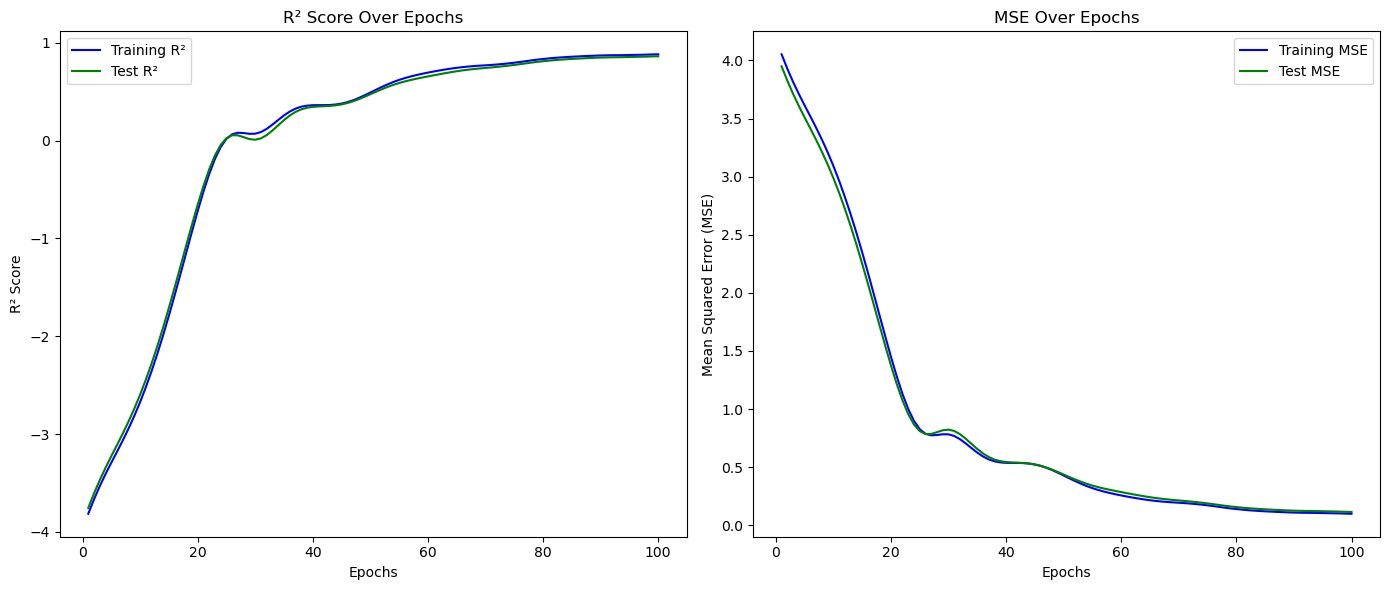

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot R² for training and test data
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_r2_list, label='Training R²', color='b')
plt.plot(range(1, num_epochs + 1), test_r2_list, label='Test R²', color='g')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('R² Score Over Epochs')
plt.legend()

# Plot MSE for training and test data
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_mse_list, label='Training MSE', color='b')
plt.plot(range(1, num_epochs + 1), test_mse_list, label='Test MSE', color='g')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
